https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

In [23]:
import time
import os

# This guide can only be run with the TensorFlow backend.
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot
import pandas as pd


In [14]:
def get_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x1 = keras.layers.Dense(64, activation="relu")(inputs)
    x2 = keras.layers.Dense(64, activation="relu")(x1)
    outputs = keras.layers.Dense(10, name="predictions")(x2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 10)                650       
                                                                 
Total params: 55050 (215.04 KB)
Trainable params: 55050 (215.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

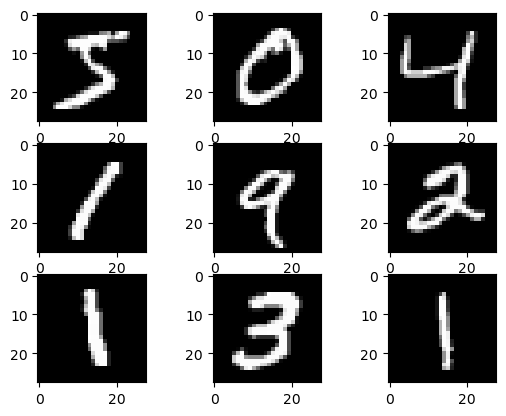

In [16]:

# Prepare the training dataset.
batch_size = 32
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Plot the first 9 images
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [17]:
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [18]:
epochs = 3
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 100 batches.
        if step % 100 == 0:
            print(
                f"Training loss (for 1 batch) at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {(step + 1) * batch_size} samples")

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {float(train_acc):.4f}")

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_state()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_state()
    print(f"Validation acc: {float(val_acc):.4f}")
    print(f"Time taken: {time.time() - start_time:.2f}s")


Start of epoch 0
Training loss (for 1 batch) at step 0: 146.7923
Seen so far: 32 samples
Training loss (for 1 batch) at step 100: 5.8643
Seen so far: 3232 samples
Training loss (for 1 batch) at step 200: 3.2807
Seen so far: 6432 samples
Training loss (for 1 batch) at step 300: 1.8453
Seen so far: 9632 samples
Training loss (for 1 batch) at step 400: 3.5848
Seen so far: 12832 samples
Training loss (for 1 batch) at step 500: 2.6508
Seen so far: 16032 samples
Training loss (for 1 batch) at step 600: 1.1264
Seen so far: 19232 samples
Training loss (for 1 batch) at step 700: 0.7503
Seen so far: 22432 samples
Training loss (for 1 batch) at step 800: 0.4854
Seen so far: 25632 samples
Training loss (for 1 batch) at step 900: 0.7031
Seen so far: 28832 samples
Training loss (for 1 batch) at step 1000: 0.8264
Seen so far: 32032 samples
Training loss (for 1 batch) at step 1100: 0.1448
Seen so far: 35232 samples
Training loss (for 1 batch) at step 1200: 0.9025
Seen so far: 38432 samples
Training l

In [25]:
pred=model.predict(x_test)
print(pred)
df_pred=pd.DataFrame(pred)
print(df_pred)

313/313 [==============================] - 0s 849us/step
[[-15.606249    7.4563313   7.262365  ...  51.545174    8.799439
   28.677656 ]
 [ 12.474138   29.18529    52.79018   ...  30.888      12.975975
  -14.477759 ]
 [-12.948922   26.59737    -6.2920575 ...  -1.5443943   3.614865
    8.48495  ]
 ...
 [ -5.403415    0.753321    9.78684   ...  18.208649    5.754891
   14.152734 ]
 [-13.005372  -10.24537    -4.2661757 ...  -3.8346884   9.683343
    5.8456173]
 [  9.645528   -7.0005426   9.71726   ...  -4.7801266   6.211757
   -3.9992483]]
              0          1          2          3          4          5  \
0    -15.606249   7.456331   7.262365  18.898455   7.585519  20.260174   
1     12.474138  29.185289  52.790180  27.448967  25.925596  42.674412   
2    -12.948922  26.597370  -6.292058 -13.573503   9.007357   3.961424   
3     17.878136 -10.384191   1.332510  -5.585006   1.983805   2.243998   
4     -2.538690   2.079390   8.818985   0.731783  21.744692  -0.534012   
...         .

In [22]:
print(y_test)

[7 2 1 ... 4 5 6]
